# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Run a pre-trained detectron2 model

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

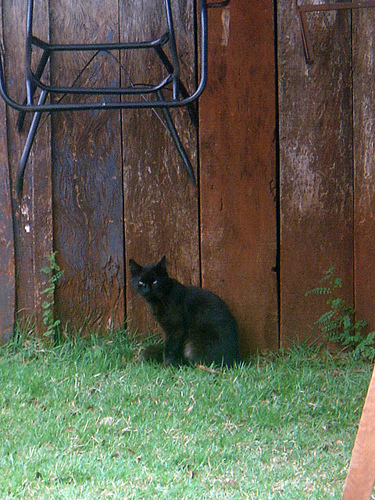

In [8]:
#!wget https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/cat_relaxing_on_patio_other/1800x1200_cat_relaxing_on_patio_other.jpg -q -O cat.jpg
im = cv2.imread("/content/drive/My Drive/CS 230/real_cats/CAT_00/00000004_007.jpg")
cv2_imshow(im)
outputs = predictor(im)

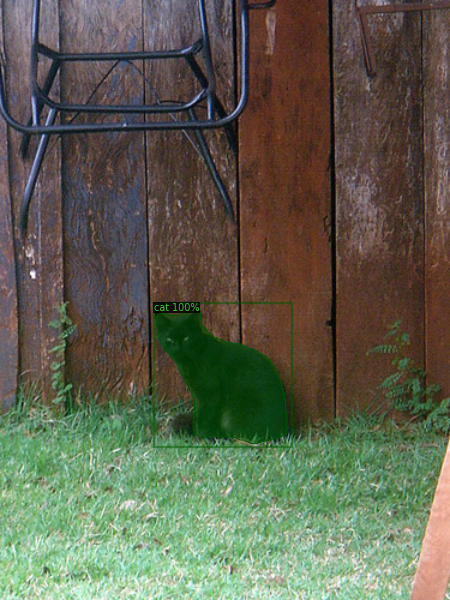

In [9]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from PIL import Image
import cv2
import math  

In [11]:
#get prediction
outputs = predictor(im)

#get boxes and masks
ins = outputs["instances"]
(ins.get_fields()['pred_classes'] == 15).nonzero().flatten().tolist()

[0]

In [127]:
def process_image(img, size, padColor = 255):
    
    h, w = img.shape[:2]
    border = 30
    sh, sw = size[0] - border*2, size[1] - border*2

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top+border, pad_bot+border, pad_left+border, pad_right+border, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [128]:
#function to get the cat image.
def get_cropped_cat(img, predictor, resize=None):
    #convert to numpy    
    img = np.array(img)[:,:,::-1]  # RGB -> BGR conversion
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    #get prediction
    outputs = predictor(img)
    
    #get boxes and masks
    ins = outputs["instances"]
    
    # only care about cats
    if 15 not in ins.get_fields()['pred_classes']:
      return
    matches = (ins.get_fields()['pred_classes'] == 15).nonzero().flatten().tolist()
    if len(matches) != 1:
      return
    idx = matches[0]
    pred_masks = ins.get_fields()["pred_masks"]
    
    #get main cart mask if the area is >= the mean area of boxes and is closes to the centre 
    mask = pred_masks[idx].to("cpu").numpy().astype(np.uint8)

    #mask image
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0]
    out = 255 - np.zeros_like(img)
    out[mask == 1] = img[mask == 1]

    # crop
    (y, x) = np.where(mask == 1)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))

    # image is too small
    if bottomy - topy < 150 or bottomx - topx < 150:
      return

    out = out[topy:bottomy+1, topx:bottomx+1]
    return cv2.cvtColor(process_image(out, (256, 256)), cv2.COLOR_BGR2RGB)

In [129]:
img = get_cropped_cat(Image.open("/content/drive/My Drive/CS 230/real_cats/CAT_00/00000001_005.jpg"),
                      predictor, resize=None);

(256, 256, 3)


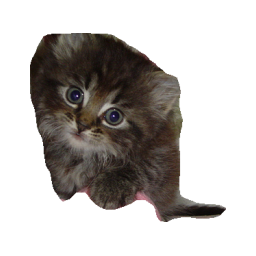

In [130]:
if not img is None:
  print(img.shape)
  cv2_imshow(img)

In [136]:
for s in ('00','01','02','03','04','05','06'):
  source_dir = "/content/drive/My Drive/CS 230/real_cats/CAT_"+s+'/'
  target_dir = "/content/drive/My Drive/CS 230/real_cats_cropped/"
  count = 0
  total = len(os.listdir(source_dir))
  saved = set(os.listdir(target_dir))
  print('running: ' + s)
  for filename in sorted(os.listdir(source_dir)):
      # for debugging
      count += 1
      if count % 100 == 0:
          print(f'progress: {count}/{total}')
      if not filename.endswith("jpg"): 
        continue
      if filename in saved:
        continue
      # detect and crop
      img = get_cropped_cat(Image.open(source_dir+filename),
                    predictor, resize=None)
      if img is None:
        continue
      # save img
      cv2.imwrite(target_dir+filename, img)
    

running: 00
progress: 100/1707
progress: 200/1707
progress: 300/1707
progress: 400/1707
progress: 500/1707
progress: 600/1707
progress: 700/1707
progress: 800/1707
progress: 900/1707
progress: 1000/1707
progress: 1100/1707
progress: 1200/1707
progress: 1300/1707
progress: 1400/1707
progress: 1500/1707
progress: 1600/1707
progress: 1700/1707
running: 01
progress: 100/1619
progress: 200/1619
progress: 300/1619
progress: 400/1619
progress: 500/1619
progress: 600/1619
progress: 700/1619
progress: 800/1619
progress: 900/1619
progress: 1000/1619
progress: 1100/1619
progress: 1200/1619
progress: 1300/1619
progress: 1400/1619
progress: 1500/1619
progress: 1600/1619
running: 02
progress: 100/1758
progress: 200/1758
progress: 300/1758
progress: 400/1758
progress: 500/1758
progress: 600/1758
progress: 700/1758
progress: 800/1758
progress: 900/1758
progress: 1000/1758
progress: 1100/1758
progress: 1200/1758
progress: 1300/1758
progress: 1400/1758
progress: 1500/1758
progress: 1600/1758
progress: 1